# A basic Demonstration of MetaCast

MetaCast has been developed from the codebase used in Grunnill et al. (2024). MetaCast's main feature is broad*CAST*ing epidemiological and ecological subpopulation models over multiple dimensions (axis) to form a *META*population model.

This notebook uses a disease X SEIHR (Susceptible - Exposed - Infected - Hospitalised - Recovered) subpopulation model as a motivating example. In possible scenarios in outbreak of disease X that epidemiological modellers my wish to simulate:
1. Risk-Structured: Single Dimension/Axis disease X model.
2. Seeding at 10% prevalence: Multinomial seeder
3. A Rapid Pathogen test: Discrete Event simulation within a 2 dimensional/axis disease X model.
4. New Vaccine: Multi Dimension/Axis disease X model with flows between some subpopulations.
5. New Vaccine's Efficacy is Uncertain: Latin Hypercube Sampling in simulation of a 2 dimensional/axis disease X model.


# 1. Risk-Structured: Single Dimension/Axis disease X model.

Import MetaCast's main class MetaCaster.

In [1]:
from metacast import MetaCaster

## 1.1 MetaCaster setup
### 1.1.1 Define subpopulation model.

This is the function that is your subpopulation model that MetaCaster will broadcast across the metapopulation generated by your scaffold (see 1.2).
The arguments are required

In [2]:
def subpop_model(y, y_deltas, parameters, states_index, subpop_suffix, foi):
    """
    Calculate derivatives of variables in disease X's subpopulation model

    Parameters
    ----------
    y : numpy.Array
        An array of the state variables at this time.
    y_deltas : numpy.Array
        The derivatives of y at this time.
    parameters : dict {str:Number or callable}
        A dictionary of parameter values.
    states_index : dict {str:int}

    subpop_suffix : str

    foi : float
        Force of infection experienced be susceptible hosts in this subpopulation.

    Returns
    -------
    y_deltas : numpy.Array
        y_deltas with derivatives of variables in disease X's subpopulation model added to.

    """
    infections = foi * y[states_index['S']]
    progression_from_exposed = parameters['sigma'] * y[states_index['E']]
    probability_of_hospitalisation = parameters['p' + subpop_suffix] # this is our subpopulation specific parameter
    progression_from_infectious = y[states_index['I']]*parameters['gamma']
    recovery = progression_from_infectious*(1-probability_of_hospitalisation)
    hospitalisation = progression_from_infectious*probability_of_hospitalisation
    hospital_recovery = y[states_index['H']]*parameters['eta']


    # Updating y_deltas with derivative calculations from this subpopulation.
    y_deltas[states_index['S']] += - infections
    y_deltas[states_index['E']] += infections - progression_from_exposed
    y_deltas[states_index['I']] += progression_from_exposed - progression_from_infectious
    y_deltas[states_index['H']] += hospitalisation - hospital_recovery
    y_deltas[states_index['R']] += recovery+hospital_recovery
    y_deltas[-2] += hospitalisation - hospital_recovery
    y_deltas[-1] += hospitalisation

    return y_deltas

### 1.1.2 Define metapopulation scaffold.

In this first we are assuming structure comes from just the risk of hospitalisation (low and high). Simulations are going to be over 90 days. Therefore, we will assume no flows of population between subpopulations. As we are dealing with a one dimension axis metapopulation we can provide a set of strings as our scaffold (a list/tuple of unique strings is also acceptable. **Note** if dealing with a multidimensional metapopulation the scaffold would have to be a list/tuple of sets of strings.

In [3]:
risk_groups = ['low', 'high']

### 1.1.3 Define model attributes

In [4]:
model_attributes = {'states': ['S', 'E', 'I', 'H', 'R'],
                    'infected_states': ['E', 'I'],
                    'infectious_states': ['I'],
                    'symptomatic_states': ['I'],
                    'observed_states': ['H','H_cumulative'],
                    'universal_params': ['sigma', 'gamma', 'eta'],
                    'subpop_params': ['p']}

### 1.1.3 Intialise MetaCaster.

In [5]:
metapop_model = MetaCaster(scaffold=risk_groups, model_attributes=model_attributes, subpop_model=subpop_model)

# 1.2 Running model
## 1.2.1 Setting population

In [6]:
import numpy as np
metapop_model.num_states

12

In [7]:
state_index_dict_high = metapop_model.state_index['high']
state_index_dict_low = metapop_model.state_index['low']
display(state_index_dict_low, state_index_dict_high)

{'S': 0, 'E': 1, 'I': 2, 'H': 3, 'R': 4}

{'S': 5, 'E': 6, 'I': 7, 'H': 8, 'R': 9}

In [8]:
N = 1e6
proportion_high_risk = 0.1
low_risk_population = N*(1-proportion_high_risk)
high_risk_population = N*proportion_high_risk
y = np.zeros(metapop_model.num_states)
y[state_index_dict_low['S']] = low_risk_population-1
y[state_index_dict_low['I']] = 1
y[state_index_dict_high['S']] = high_risk_population
y

array([8.99999e+05, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
       1.00000e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00])

### 1.2.2 Setting up parameters

In [9]:
metapop_model.parameter_names

['beta_[high]',
 'beta_[low]',
 'eta',
 'gamma',
 'p_[high]',
 'p_[low]',
 'rho_[high]_[high]',
 'rho_[high]_[low]',
 'rho_[low]_[high]',
 'rho_[low]_[low]',
 'sigma']

In [10]:
non_subpop_parameters = {'eta': 1/5, 'gamma': 1/7,  'sigma': 1/3}
p_high = 0.3
p_high = 0.01
hospitalisation_probs = {'p_[high]': p_high, 'p_[low]': p_high}
beta = (2/7)/N
beta_parameters = {'beta'+ subpop_suffix: beta for subpop_suffix in metapop_model.subpop_suffixes}
subpopulation_interactions = 1
interaction_parameters = {'rho'+ subpop_suffix_i+subpop_suffix_j: subpopulation_interactions
                          for subpop_suffix_i in metapop_model.subpop_suffixes
                          for subpop_suffix_j in metapop_model.subpop_suffixes}
parameters = {**non_subpop_parameters,
              **hospitalisation_probs,
              **beta_parameters,
              **interaction_parameters}
metapop_model.parameters = parameters
parameters

{'eta': 0.2,
 'gamma': 0.14285714285714285,
 'sigma': 0.3333333333333333,
 'p_[high]': 0.3,
 'p_[low]': 0.01,
 'beta_[low]': 2.857142857142857e-07,
 'beta_[high]': 2.857142857142857e-07,
 'rho_[low]_[low]': 1,
 'rho_[low]_[high]': 1,
 'rho_[high]_[low]': 1,
 'rho_[high]_[high]': 1}

### 1.2.3 Run metapopulation model

In [11]:
#set time
end_day = 90
time_step = 1
t = np.arange(0, end_day+time_step, time_step)
t

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90])

In [12]:
results_1 = metapop_model.integrate(y,t)
results_1

low                                                  \
                S           E            I         H            R   
0   899999.000000    0.000000     1.000000  0.000000     0.000000   
1   899998.756863    0.206203     0.902053  0.001220     0.133660   
2   899998.528128    0.342128     0.868956  0.002140     0.258649   
3   899998.299639    0.439570     0.875754  0.002878     0.382159   
4   899998.062612    0.516814     0.908351  0.003510     0.508713   
..            ...         ...          ...       ...          ...   
86  897111.545018  584.777444   857.527688  4.305178  1441.844671   
87  896856.751838  636.194751   933.078650  4.684948  1569.289813   
88  896579.598102  692.096376  1015.246741  5.098066  1707.960715   
89  896278.141473  752.866680  1104.604306  5.547433  1858.840108   
90  895950.274569  818.921720  1201.771874  6.036197  2022.995640   

             high                                                \
                S          E           I          H           R   
0   100000.000000   0.000000    0.000000   0.000000    0.000000   
1    99999.972985   0.022911    0.003908   0.000056    0.000140   
2    99999.947570   0.038014    0.013053   0.000369    0.000994   
3    99999.922182   0.048841    0.024924   0.001041    0.003012   
4    99999.895846   0.057424    0.038181   0.002084    0.006465   
..            ...        ...         ...        ...         ...   
86   99679.171312  64.975344   95.280960  14.350610  146.221775   
87   99650.860927  70.688384  103.675520  15.616509  159.158659   
88   99620.066034  76.899683  112.805318  16.993571  173.235394   
89   99586.570815  83.651946  122.733948  18.491464  188.551827   
90   99550.141119  90.991403  133.530356  20.120679  205.216442   

   observed_states               
                 H H_cumulative  
0         0.000000     0.000000  
1         0.001276     0.001407  
2         0.002509     0.003017  
3         0.003919     0.005066  
4         0.005593     0.007687  
..             ...          ...  
86       18.655788    62.633214  
87       20.301457    68.172298  
88       22.091637    74.199277  
89       24.038897    80.756863  
90       26.156877    87.891455  

[91 rows x 12 columns]

### 1.2.4 Plotting hospitalisations

In [13]:
import seaborn as sns

In [14]:
def melt_results_and_plot_hospitalised(results):
    results['t'] = t
    results_melted = results.melt(id_vars=['t'],var_name=['Subpopulation', 'State']) # melt results for using seaborn
    hospitalised_results = results_melted[results_melted['State']=='H']
    sns.lineplot(hospitalised_results,x='t',y='value',hue='Subpopulation')
    return results_melted

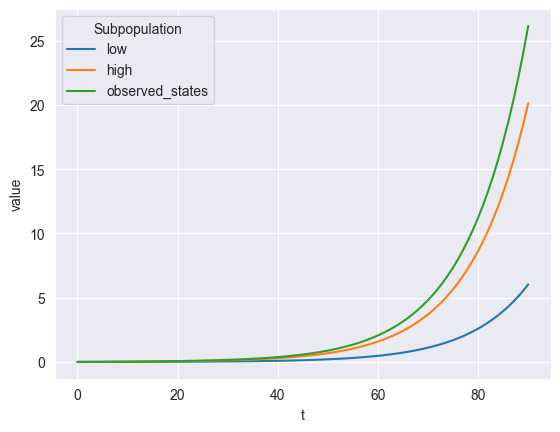

In [15]:
results_1_melted = melt_results_and_plot_hospitalised(results_1)

In [16]:
# Total Hospitalised
display({'Total hospitalisations': results_1.loc[90,('observed_states','H_cumulative')],
         'Peak hospitalisations': max(results_1.loc[:,('observed_states','H')])})

{'Total hospitalisations': 87.89145481017233,
 'Peak hospitalisations': 26.15687669462622}

# 2.
## 2.1 Set up Seeders

In [17]:
from metacast import MultnomialSeeder

In [18]:
seeding_info = {'unhospitalised': {'E': 'sigma','I':'gamma'},
                'hospitalised': {'E': 'sigma','I':'gamma', 'H':'eta'},
                }
seeder = MultnomialSeeder(seeding_info)
seeder.set_seed(42) # This class uses random number generation (rng) use set_seed function to set rng seed.

## 2.2 Setup Populations with seeder

In [19]:
prevelance = 0.1
low_risk_total_infected = low_risk_population*prevelance
low_risk_infected = seeder.seed_infections(n=low_risk_total_infected,
                                           branch_probability={'unhospitalised': 1- parameters['p_[low]'] ,'hospitalised': parameters['p_[low]']},
                                           parameters=parameters)
low_risk_infected

{'H': 283, 'E': 26655, 'I': 63062}

In [20]:
high_risk_total_infected = high_risk_population*prevelance
high_risk_infected = seeder.seed_infections(n=high_risk_total_infected,
                                            branch_probability={'unhospitalised': 1- parameters['p_[high]'] ,'hospitalised': parameters['p_[high]']},
                                            parameters=parameters)
high_risk_infected

{'H': 961, 'E': 2762, 'I': 6277}

In [21]:
y =np.zeros(metapop_model.num_states)
low_risk_state_pops = {'S':low_risk_population*(1-prevelance), **low_risk_infected}
for state, index in state_index_dict_low.items():
    if state in low_risk_state_pops:
        y[index] = low_risk_state_pops[state]

y

array([8.1000e+05, 2.6655e+04, 6.3062e+04, 2.8300e+02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00])

In [22]:
high_risk_state_pops = {'S':high_risk_population*(1-prevelance), **high_risk_infected}
for state, index in state_index_dict_high.items():
    if state in high_risk_state_pops:
        y[index] = high_risk_state_pops[state]

y[-2] += low_risk_state_pops['H'] + high_risk_state_pops['H']
y

array([8.1000e+05, 2.6655e+04, 6.3062e+04, 2.8300e+02, 0.0000e+00,
       9.0000e+04, 2.7620e+03, 6.2770e+03, 9.6100e+02, 0.0000e+00,
       1.2440e+03, 0.0000e+00])

### 2.3 Run metapopulation model

In [23]:
results_seeded = metapop_model.integrate(y,t)
results_seeded

low                                                         \
                S             E             I           H              R   
0   810000.000000  26655.000000  63062.000000  283.000000       0.000000   
1   794032.457332  32676.313346  63957.663269  313.750061    9019.815992   
2   777950.107544  37096.680089  66327.048240  341.151315   18285.012812   
3   761491.029955  40588.698577  69593.747479  367.300536   27959.223453   
4   744524.668972  43524.208597  73414.831722  393.338589   38142.952120   
..            ...           ...           ...         ...            ...   
86  156864.620524    535.185068   2737.599077   31.692935  739830.902397   
87  156733.510341    494.731038   2532.887573   29.353928  740209.517119   
88  156612.305201    457.339510   2343.355145   27.184133  740559.816012   
89  156500.255982    422.778024   2167.894953   25.171781  740883.899261   
90  156396.670333    390.831847   2005.478148   23.305856  741183.713816   

            high                                                       \
               S            E            I            H             R   
0   90000.000000  2762.000000  6277.000000   961.000000      0.000000   
1   88225.828592  3487.634064  6421.148879  1032.801942    832.586522   
2   86438.900838  4019.341059  6737.994908  1100.940429   1702.822767   
3   84610.114439  4436.402136  7158.080022  1171.276980   2624.126422   
4   82724.963219  4783.391616  7639.805351  1246.521660   3605.318154   
..           ...          ...          ...          ...           ...   
86  17429.402280    59.465008   304.172692   105.639410  82101.320610   
87  17414.834482    54.970115   281.427633    97.843213  82150.924557   
88  17401.367245    50.815501   260.369049    90.610989  82196.837216   
89  17388.917331    46.975336   240.873971    83.903518  82239.329844   
90  17377.407815    43.425761   222.828091    77.684090  82278.654243   

   observed_states                
                 H  H_cumulative  
0      1244.000000      0.000000  
1      1346.552003    361.822200  
2      1442.091744    736.260600  
3      1538.577516   1130.756261  
4      1639.860249   1549.784851  
..             ...           ...  
86      137.332345  31769.583959  
87      127.197141  31785.889041  
88      117.795122  31800.974463  
89      109.075299  31814.930719  
90      100.989946  31827.841697  

[91 rows x 12 columns]

### 2.4 Plotting hospitalisations

,t,Subpopulation,State,value
0,0,low,S,810000.000000
1,1,low,S,794032.457332
2,2,low,S,777950.107544
3,3,low,S,761491.029955
4,4,low,S,744524.668972
...,...,...,...,...
1087,86,observed_states,H_cumulative,31769.583959
1088,87,observed_states,H_cumulative,31785.889041
1089,88,observed_states,H_cumulative,31800.974463
1090,89,observed_states,H_cumulative,31814.930719


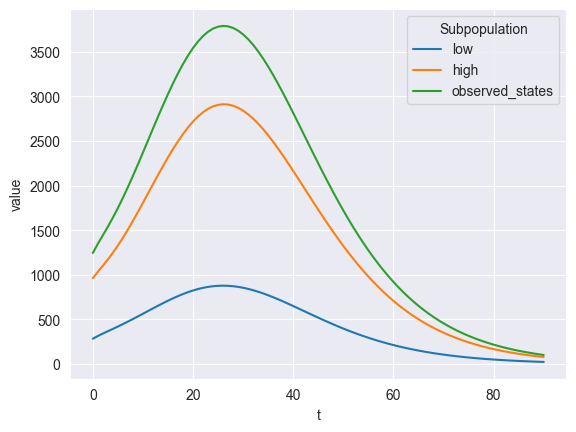

In [24]:
melt_results_and_plot_hospitalised(results_seeded)

In [25]:
display({'Total hospitalisations': results_seeded.loc[90,('observed_states','H_cumulative')],
         'Peak hospitalisations': max(results_seeded.loc[:,('observed_states','H')])})

{'Total hospitalisations': 31827.841696731277,
 'Peak hospitalisations': 3788.607630940858}

# 3. A Rapid Pathogen test: Discrete Event simulation within a 2 dimensional/axis disease X model.

## 3.1 Change Population Structure

In [26]:
isolation_groups = ['negative','positive']
rapid_pathogen_test_scaffold = [risk_groups,isolation_groups]

In [27]:
metapop_model.set_structure(rapid_pathogen_test_scaffold)
metapop_model.subpops

[{'high', 'low'}, {'negative', 'positive'}]

## 3.2 Set Population

In [28]:
metapop_model.state_index

{('low', 'negative'): {'S': 0, 'E': 1, 'I': 2, 'H': 3, 'R': 4},
 ('low', 'positive'): {'S': 5, 'E': 6, 'I': 7, 'H': 8, 'R': 9},
 ('high', 'negative'): {'S': 10, 'E': 11, 'I': 12, 'H': 13, 'R': 14},
 ('high', 'positive'): {'S': 15, 'E': 16, 'I': 17, 'H': 18, 'R': 19},
 'observed_states': {'H': 20, 'H_cumulative': 21}}

In [29]:
y =np.zeros(metapop_model.num_states)
low_risk_state_pops = {'S':low_risk_population*(1-prevelance), **low_risk_infected}
for state, index in metapop_model.state_index[('low', 'negative')].items():
    if state in low_risk_state_pops:
        y[index] = low_risk_state_pops[state]
high_risk_state_pops = {'S':high_risk_population*(1-prevelance), **high_risk_infected}
for state, index in metapop_model.state_index[('high', 'negative')].items():
    if state in high_risk_state_pops:
        y[index] = high_risk_state_pops[state]

y[-2] += low_risk_state_pops['H'] + high_risk_state_pops['H']
y

array([8.1000e+05, 2.6655e+04, 6.3062e+04, 2.8300e+02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       9.0000e+04, 2.7620e+03, 6.2770e+03, 9.6100e+02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       1.2440e+03, 0.0000e+00])

## 3.3 Set parameters

In [30]:
metapop_model.parameter_names

['beta_[high,negative]',
 'beta_[high,positive]',
 'beta_[low,negative]',
 'beta_[low,positive]',
 'eta',
 'gamma',
 'p_[high,negative]',
 'p_[high,positive]',
 'p_[low,negative]',
 'p_[low,positive]',
 'rho_[high,negative]_[high,negative]',
 'rho_[high,negative]_[high,positive]',
 'rho_[high,negative]_[low,negative]',
 'rho_[high,negative]_[low,positive]',
 'rho_[high,positive]_[high,negative]',
 'rho_[high,positive]_[high,positive]',
 'rho_[high,positive]_[low,negative]',
 'rho_[high,positive]_[low,positive]',
 'rho_[low,negative]_[high,negative]',
 'rho_[low,negative]_[high,positive]',
 'rho_[low,negative]_[low,negative]',
 'rho_[low,negative]_[low,positive]',
 'rho_[low,positive]_[high,negative]',
 'rho_[low,positive]_[high,positive]',
 'rho_[low,positive]_[low,negative]',
 'rho_[low,positive]_[low,positive]',
 'sigma']

In [31]:
beta_parameters = {'beta' + subpop_suffix: beta for subpop_suffix in metapop_model.subpop_suffixes}
hospitalisation_probs = {
    **{'p_[high,'+ isolation_group +']': p_high for isolation_group in isolation_groups},
    **{'p_[low,'+ isolation_group +']': p_high for isolation_group in isolation_groups}
}

In [32]:
transmission_reduction_from_isolation = 0.6
interaction_parameters = {
    **{'rho'+ subpop_suffix_i+'_['+risk_group +',negative]': subpopulation_interactions
       for subpop_suffix_i in metapop_model.subpop_suffixes
       for risk_group in risk_groups},
    **{'rho'+ subpop_suffix_i+'_['+risk_group +',positive]': subpopulation_interactions*(1-transmission_reduction_from_isolation)
       for subpop_suffix_i in metapop_model.subpop_suffixes
       for risk_group in risk_groups}
}
interaction_parameters

{'rho_[low,negative]_[low,negative]': 1,
 'rho_[low,negative]_[high,negative]': 1,
 'rho_[low,positive]_[low,negative]': 1,
 'rho_[low,positive]_[high,negative]': 1,
 'rho_[high,negative]_[low,negative]': 1,
 'rho_[high,negative]_[high,negative]': 1,
 'rho_[high,positive]_[low,negative]': 1,
 'rho_[high,positive]_[high,negative]': 1,
 'rho_[low,negative]_[low,positive]': 0.4,
 'rho_[low,negative]_[high,positive]': 0.4,
 'rho_[low,positive]_[low,positive]': 0.4,
 'rho_[low,positive]_[high,positive]': 0.4,
 'rho_[high,negative]_[low,positive]': 0.4,
 'rho_[high,negative]_[high,positive]': 0.4,
 'rho_[high,positive]_[low,positive]': 0.4,
 'rho_[high,positive]_[high,positive]': 0.4}

In [33]:
parameters = {**non_subpop_parameters,
              **hospitalisation_probs,
              **beta_parameters,
              **interaction_parameters}
metapop_model.parameters = parameters

## 3.4 Set up Event Que

Import EventQueue and TransferEvent

In [34]:
from metacast.event_handling import EventQueue, TransferEvent

In [35]:
from_index = [index
              for risk_group in risk_groups
              for state, index in metapop_model.state_index[(risk_group,'negative')].items()
              if state in ['E','I']]
to_index = [index
            for risk_group in risk_groups
            for state, index in metapop_model.state_index[(risk_group,'positive')].items()
            if state in ['E','I']]
display(from_index,to_index)

[1, 2, 11, 12]

[6, 7, 16, 17]

In [36]:
test_every_x_days = 7
test_sensitivity = 0.6
rapid_pathogen_test_event = TransferEvent(name='Rapid pathogen test',
                                          times= range(0,end_day+time_step,test_every_x_days),
                                          proportion= test_sensitivity,
                                          from_index= from_index,
                                          to_index= to_index)


testing_eventqueue = EventQueue(rapid_pathogen_test_event)

## 3.5 Run simulations with Events

In [37]:
results_rapid_test, transfer_df = testing_eventqueue.run_simulation(model_object=metapop_model,
                                                                    run_attribute='integrate',
                                                                    parameters=parameters,
                                                                    parameters_attribute='parameters',
                                                                    y0=y,
                                                                    end_time=end_day,
                                                                    start_time=0,
                                                                    simulation_step=time_step)
results_rapid_test

low,negative                                                         \
                S             E             I           H              R   
0   810000.000000  10662.000000  25224.800000  283.000000       0.000000   
1   799743.948294  16362.112537  26133.292372  264.779332    3665.667466   
2   789335.860142  20581.246888  28437.131352  252.045525    7563.516093   
3   778594.092492  23891.327418  31588.982391  245.215691   11850.182007   
4   767415.133999  26636.678410  35252.819562  244.075374   16621.092655   
..            ...           ...           ...         ...            ...   
86  417344.436743    799.488817   1120.034199   13.496069  180920.199939   
87  417001.236003    864.601533   1230.310377   12.572985  181088.934868   
88  416662.565440    907.424149   1342.373895   11.962031  181273.330252   
89  416327.751045    934.840953   1450.225102   11.604591  181473.234076   
90  415996.371691    951.572502   1550.435701   11.446740  181687.829134   

   low,positive                                                         ...  \
              S             E             I           H              R  ...   
0           0.0  15993.000000  37837.200000    0.000000       0.000000  ...   
1           0.0  11459.485262  37008.095198   48.585669    5314.033870  ...   
2           0.0   8211.079979  35096.565279   86.504009   10436.050733  ...   
3           0.0   5883.495881  32584.825598  114.630211   15247.248310  ...   
4           0.0   4215.708993  29795.051406  134.191968   19685.247633  ...   
..          ...           ...           ...         ...            ...  ...   
86          0.0    499.222777   3724.576537   32.893503  295545.651416  ...   
87          0.0    357.708756   3360.101850   31.509067  296053.024560  ...   
88          0.0    256.309522   3006.913547   29.909961  296509.211203  ...   
89          0.0    183.653795   2674.063614   28.156312  296916.470512  ...   
90          0.0    131.593692   2366.407166   26.306082  297278.037292  ...   

   high,negative                           high,positive               \
               I           H             R             S            E   
0    2510.800000  961.000000      0.000000           0.0  1657.200000   
1    2629.595892  886.063681    439.716191           0.0  1187.435689   
2    2907.010414  832.764896    887.039935           0.0   850.834849   
3    3280.063498  801.979784   1358.891366           0.0   609.649808   
4    3710.020682  792.504679   1867.148107           0.0   436.833173   
..           ...         ...           ...           ...          ...   
86    124.448244   44.986884  20724.599686           0.0    55.469197   
87    136.701153   41.909940  20746.322390           0.0    39.745417   
88    149.152655   39.873430  20768.779393           0.0    28.478836   
89    161.136122   38.681962  20792.142680           0.0    20.405977   
90    172.270633   38.155794  20816.495205           0.0    14.621521   

                                          observed_states                
              I           H             R               H  H_cumulative  
0   3766.200000    0.000000      0.000000     1244.000000      0.000000  
1   3700.855687  145.454728    389.653896     1344.883410    360.067212  
2   3520.612093  259.502931    792.450127     1430.817360    723.778530  
3   3275.801026  344.448415   1193.500752     1506.274101   1093.088857  
4   3000.122363  403.779491   1582.664973     1574.551512   1469.545251  
..          ...         ...           ...             ...           ...  
86   413.836854  109.641317  32066.581644      201.017773  20357.735269  
87   373.340330  105.027020  32127.416245      191.019013  20386.933093  
88   334.097760   99.697090  32183.255326      181.442512  20414.595706  
89   297.114933   93.851963  32234.156140      172.294828  20440.814479  
90   262.931315   87.684850  32280.291325      163.593467  20465.694345  

[91 rows x 22 columns]

In [38]:
transfer_df

,time,transfered,event
0,0,59253.600000,Rapid pathogen test
1,7,53755.987062,Rapid pathogen test
2,14,49170.491935,Rapid pathogen test
3,21,42891.508293,Rapid pathogen test
4,28,35177.410256,Rapid pathogen test
5,35,27370.026273,Rapid pathogen test
6,42,20468.820853,Rapid pathogen test
7,49,14885.733136,Rapid pathogen test
8,56,10621.192961,Rapid pathogen test
9,63,7482.450783,Rapid pathogen test


### 3.6 Plotting hospitalisations

,t,Subpopulation,State,value
0,0,"low,negative",S,810000.000000
1,1,"low,negative",S,799743.948294
2,2,"low,negative",S,789335.860142
3,3,"low,negative",S,778594.092492
4,4,"low,negative",S,767415.133999
...,...,...,...,...
1997,86,observed_states,H_cumulative,20357.735269
1998,87,observed_states,H_cumulative,20386.933093
1999,88,observed_states,H_cumulative,20414.595706
2000,89,observed_states,H_cumulative,20440.814479


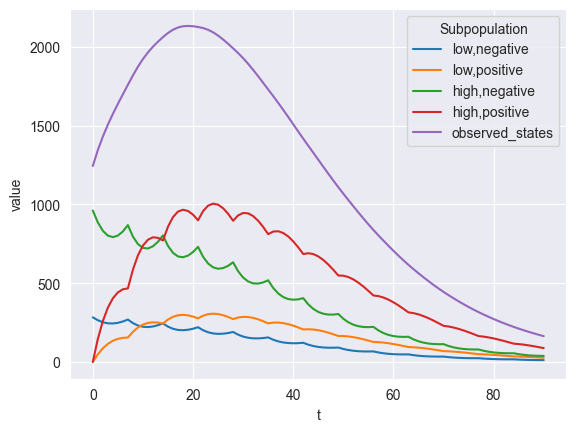

In [39]:
melt_results_and_plot_hospitalised(results_rapid_test)

In [40]:
display({'Total hospitalisations': results_rapid_test.loc[90,('observed_states','H_cumulative')],
         'Peak hospitalisations': max(results_rapid_test.loc[:,('observed_states','H')])})

{'Total hospitalisations': 20465.694345019572,
 'Peak hospitalisations': 2133.5620007085495}

## 3.6 Comparing with Rapid test event turned to null (do nothing) event.

In [41]:
y

array([8.1000e+05, 2.6655e+04, 6.3062e+04, 2.8300e+02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       9.0000e+04, 2.7620e+03, 6.2770e+03, 9.6100e+02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       1.2440e+03, 0.0000e+00])

In [42]:
metapop_model.state_index

{('low', 'negative'): {'S': 0, 'E': 1, 'I': 2, 'H': 3, 'R': 4},
 ('low', 'positive'): {'S': 5, 'E': 6, 'I': 7, 'H': 8, 'R': 9},
 ('high', 'negative'): {'S': 10, 'E': 11, 'I': 12, 'H': 13, 'R': 14},
 ('high', 'positive'): {'S': 15, 'E': 16, 'I': 17, 'H': 18, 'R': 19},
 'observed_states': {'H': 20, 'H_cumulative': 21}}

In [43]:
rapid_pathogen_test_event.make_event_a_nullevent()
results_rapid_test_null, transfer_df = testing_eventqueue.run_simulation(model_object=metapop_model,
                                                                         run_attribute='integrate',
                                                                         parameters=parameters,
                                                                         parameters_attribute='parameters',
                                                                         y0=y,
                                                                         end_time=end_day,
                                                                         start_time=0,
                                                                         simulation_step=time_step)
results_rapid_test_null

low,negative                                                         \
                S             E             I           H              R   
0   810000.000000  26655.000000  63062.000000  283.000000       0.000000   
1   794032.457332  32676.313346  63957.663269  313.750061    9019.815992   
2   777950.107544  37096.680089  66327.048240  341.151315   18285.012812   
3   761491.029955  40588.698577  69593.747479  367.300536   27959.223453   
4   744524.668972  43524.208597  73414.831722  393.338589   38142.952120   
..            ...           ...           ...         ...            ...   
86  156864.625582    535.185201   2737.599684   31.692941  739830.896592   
87  156733.515348    494.731159   2532.888122   29.353934  740209.511437   
88  156612.310181    457.339624   2343.355662   27.184139  740559.810395   
89  156500.260929    422.778129   2167.895431   25.171786  740883.893725   
90  156396.675249    390.831944   2005.478589   23.305861  741183.708356   

   low,positive                      ... high,negative               \
              S    E    I    H    R  ...             I            H   
0           0.0  0.0  0.0  0.0  0.0  ...   6277.000000   961.000000   
1           0.0  0.0  0.0  0.0  0.0  ...   6421.148879  1032.801942   
2           0.0  0.0  0.0  0.0  0.0  ...   6737.994908  1100.940429   
3           0.0  0.0  0.0  0.0  0.0  ...   7158.080022  1171.276980   
4           0.0  0.0  0.0  0.0  0.0  ...   7639.805351  1246.521660   
..          ...  ...  ...  ...  ...  ...           ...          ...   
86          0.0  0.0  0.0  0.0  0.0  ...    304.172759   105.639432   
87          0.0  0.0  0.0  0.0  0.0  ...    281.427694    97.843234   
88          0.0  0.0  0.0  0.0  0.0  ...    260.369106    90.611008   
89          0.0  0.0  0.0  0.0  0.0  ...    240.874024    83.903536   
90          0.0  0.0  0.0  0.0  0.0  ...    222.828140    77.684107   

                 high,positive                     observed_states  \
               R             S    E    I    H    R               H   
0       0.000000           0.0  0.0  0.0  0.0  0.0     1244.000000   
1     832.586522           0.0  0.0  0.0  0.0  0.0     1346.552003   
2    1702.822767           0.0  0.0  0.0  0.0  0.0     1442.091744   
3    2624.126422           0.0  0.0  0.0  0.0  0.0     1538.577516   
4    3605.318154           0.0  0.0  0.0  0.0  0.0     1639.860249   
..           ...           ...  ...  ...  ...  ...             ...   
86  82101.319944           0.0  0.0  0.0  0.0  0.0      137.332374   
87  82150.923905           0.0  0.0  0.0  0.0  0.0      127.197168   
88  82196.836574           0.0  0.0  0.0  0.0  0.0      117.795147   
89  82239.329211           0.0  0.0  0.0  0.0  0.0      109.075322   
90  82278.653620           0.0  0.0  0.0  0.0  0.0      100.989968   

                  
    H_cumulative  
0       0.000000  
1     361.822200  
2     736.260600  
3    1130.756261  
4    1549.784851  
..           ...  
86  31769.583708  
87  31785.888795  
88  31800.974220  
89  31814.930479  
90  31827.841460  

[91 rows x 22 columns]

In [44]:
transfer_df

,time,transfered,event
0,0,None,Rapid pathogen test
1,7,None,Rapid pathogen test
2,14,None,Rapid pathogen test
3,21,None,Rapid pathogen test
4,28,None,Rapid pathogen test
5,35,None,Rapid pathogen test
6,42,None,Rapid pathogen test
7,49,None,Rapid pathogen test
8,56,None,Rapid pathogen test
9,63,None,Rapid pathogen test


,t,Subpopulation,State,value
0,0,"low,negative",S,810000.000000
1,1,"low,negative",S,794032.457332
2,2,"low,negative",S,777950.107544
3,3,"low,negative",S,761491.029955
4,4,"low,negative",S,744524.668972
...,...,...,...,...
1997,86,observed_states,H_cumulative,31769.583708
1998,87,observed_states,H_cumulative,31785.888795
1999,88,observed_states,H_cumulative,31800.974220
2000,89,observed_states,H_cumulative,31814.930479


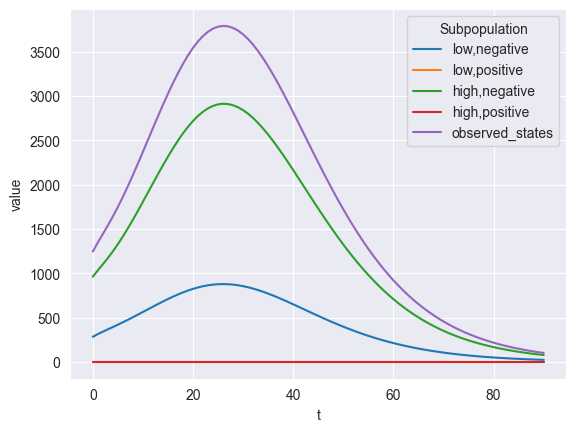

In [45]:
melt_results_and_plot_hospitalised(results_rapid_test_null)

In [46]:
display({'Total hospitalisations': results_rapid_test_null.loc[90,('observed_states','H_cumulative')],
         'Peak hospitalisations': max(results_rapid_test_null.loc[:,('observed_states','H')])})

{'Total hospitalisations': 31827.84146034985,
 'Peak hospitalisations': 3788.607576827358}

# 4. Two New Vaccines of known efficacy: Multi Dimension/Axis disease X model with flows between subpopulations.

## 4.1 Set metapopulation structure using a list of subpopulation transfer dictionaries for a scaffold.

In [47]:
vaccination_groups = ['unvaccinated','vaccination_lag' 'vaccinated']
vaccination_transfers = [{'from_coordinates': (risk_group,'unvaccinated'),
                          'to_coordinates': (risk_group,'vaccination_lag'),
                          'states': ['S'], 'parameter': 'nu_0'}
                         for risk_group in risk_groups]
vacination_lag_transfers = [{'from_coordinates': (risk_group,'vaccination_lag'),
                             'to_coordinates': (risk_group,'vaccinated'),
                             'states': 'all', 'parameter': 'nu_1'}
                            for risk_group in risk_groups]

vaccination_scaffold = vaccination_transfers + vacination_lag_transfers
vaccination_scaffold

[{'from_coordinates': ('low', 'unvaccinated'),
  'to_coordinates': ('low', 'vaccination_lag'),
  'states': ['S'],
  'parameter': 'nu_0'},
 {'from_coordinates': ('high', 'unvaccinated'),
  'to_coordinates': ('high', 'vaccination_lag'),
  'states': ['S'],
  'parameter': 'nu_0'},
 {'from_coordinates': ('low', 'vaccination_lag'),
  'to_coordinates': ('low', 'vaccinated'),
  'states': 'all',
  'parameter': 'nu_1'},
 {'from_coordinates': ('high', 'vaccination_lag'),
  'to_coordinates': ('high', 'vaccinated'),
  'states': 'all',
  'parameter': 'nu_1'}]

In [48]:
metapop_model.set_structure(vaccination_scaffold)
metapop_model.subpops

[{'high', 'low'}, {'unvaccinated', 'vaccinated', 'vaccination_lag'}]

## 4.2 Set population

In [49]:
metapop_model.num_states

32

In [50]:
y = np.zeros(metapop_model.num_states)

for state, index in metapop_model.state_index[('high','unvaccinated')].items():
    if state in high_risk_state_pops:
        y[index] = high_risk_state_pops[state]

for state, index in metapop_model.state_index[('low','unvaccinated')].items():
    if state in low_risk_state_pops:
        y[index] =low_risk_state_pops[state]

y[-2] += low_risk_state_pops['H'] + high_risk_state_pops['H']
y

array([8.1000e+05, 2.6655e+04, 6.3062e+04, 2.8300e+02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       9.0000e+04, 2.7620e+03, 6.2770e+03, 9.6100e+02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       1.2440e+03, 0.0000e+00])

## 4.3 Set parameters

In [51]:
metapop_model.parameter_names

['beta_[high,unvaccinated]',
 'beta_[high,vaccinated]',
 'beta_[high,vaccination_lag]',
 'beta_[low,unvaccinated]',
 'beta_[low,vaccinated]',
 'beta_[low,vaccination_lag]',
 'eta',
 'gamma',
 'nu_0',
 'nu_1',
 'p_[high,unvaccinated]',
 'p_[high,vaccinated]',
 'p_[high,vaccination_lag]',
 'p_[low,unvaccinated]',
 'p_[low,vaccinated]',
 'p_[low,vaccination_lag]',
 'rho_[high,unvaccinated]_[high,unvaccinated]',
 'rho_[high,unvaccinated]_[high,vaccinated]',
 'rho_[high,unvaccinated]_[high,vaccination_lag]',
 'rho_[high,unvaccinated]_[low,unvaccinated]',
 'rho_[high,unvaccinated]_[low,vaccinated]',
 'rho_[high,unvaccinated]_[low,vaccination_lag]',
 'rho_[high,vaccinated]_[high,unvaccinated]',
 'rho_[high,vaccinated]_[high,vaccinated]',
 'rho_[high,vaccinated]_[high,vaccination_lag]',
 'rho_[high,vaccinated]_[low,unvaccinated]',
 'rho_[high,vaccinated]_[low,vaccinated]',
 'rho_[high,vaccinated]_[low,vaccination_lag]',
 'rho_[high,vaccination_lag]_[high,unvaccinated]',
 'rho_[high,vaccination

In [52]:
v_day = end_day
prob_vaccinated_by_v_day = 0.95
prob_vaccinated_per_day = 1-(1-prob_vaccinated_by_v_day)**(1/v_day)
prob_vaccinated_per_day

0.032738033833534574

In [53]:
def vaccination_parameters_setup(prob_vaccinated_per_day,
                                 vaccination_lag,
                                 vaccine_reduced_susceptibility,
                                 vaccine_reduced_severity,
                                 other_parameters,
                                 metapop_model):
    parameters = {key: value for key, value in other_parameters if key in metapop_model.parameters}
    parameters.update({'nu_0': prob_vaccinated_per_day,
                       'nu_1': vaccination_lag})

    beta = other_parameters['beta']
    parameters.update({'beta_[high,unvaccinated]': beta,
                       'beta_[high,vaccinated]': beta*(1-vaccine_reduced_susceptibility),
                       'beta_[high,vaccination_lag]': beta,
                       'beta_[low,unvaccinated]': beta,
                       'beta_[low,vaccinated]': beta*(1-vaccine_reduced_susceptibility),
                       'beta_[low,vaccination_lag]': beta})

    vaccine_reduced_severity_given_reduced_susceptibility = 1-((1-vaccine_reduced_severity)/(1-vaccine_reduced_susceptibility))
    p_high = other_parameters['p_[high]']
    p_low = other_parameters['p_[low]']
    parameters.update({'p_[high,unvaccinated]': p_high,
                       'p_[high,vaccinated]': p_high*vaccine_reduced_severity_given_reduced_susceptibility,
                       'p_[high,vaccination_lag]': p_high,
                       'p_[low,unvaccinated]': p_low,
                       'p_[low,vaccinated]': p_low*vaccine_reduced_severity_given_reduced_susceptibility,
                       'p_[low,vaccination_lag]': p_low})
    rho = other_parameters['rho']
    parameters.update({'rho'+ subpop_suffix_i+subpop_suffix_j: rho
                       for subpop_suffix_i in metapop_model.subpop_suffixes
                       for subpop_suffix_j in metapop_model.subpop_suffixes})
    return parameters

vaccination_lag = 1/14
vaccine_reduced_susceptibility = 0.5
vaccine_reduced_severity = 0.8
metapop_model.parameters = parameters

### 4.4 Run metapopulation model

In [54]:
results_4 = metapop_model.integrate(y,t)
results_4

low,unvaccinated                                                         \
                  S             E             I           H              R   
0     810000.000000  26655.000000  63062.000000  283.000000       0.000000   
1     768458.315129  32444.501661  63932.061481  313.741051    9018.887034   
2     728645.086483  36262.739962  66145.234025  341.025627   18271.517004   
3     690259.332317  38876.606454  69043.734468  366.741867   27896.750812   
4     653149.439752  40716.600473  72237.072223  391.778853   37961.351250   
..              ...           ...           ...         ...            ...   
86     11438.271356     27.872190    286.008212    4.380746  448237.683424   
87     11064.300127     24.770053    256.089159    3.936605  448276.810239   
88     10702.996240     22.010770    229.244958    3.536327  448311.842542   
89     10353.882551     19.556753    205.166686    3.175732  448343.201335   
90     10016.504912     17.374501    183.575532    2.851018  448371.265296   

   low,vaccinated                                                    ...  \
                S           E            I         H              R  ...   
0        0.000000    0.000000     0.000000  0.000000       0.000000  ...   
1      899.829279    7.850259     1.094675  0.000308       0.044878  ...   
2     3419.419041   53.514074    14.877017  0.008234       1.255562  ...   
3     7306.429988  156.208018    64.567659  0.052526       8.393454  ...   
4    12328.847788  324.149022   176.320938  0.187040      31.321983  ...   
..            ...         ...          ...       ...            ...  ...   
86  226102.313537  241.157646  1310.845955  9.364966  201263.573538  ...   
87  226701.378606  222.089469  1211.727353  8.676443  201560.023293  ...   
88  227284.409292  204.482733  1119.732935  8.035323  201835.303155  ...   
89  227851.692004  188.230606  1034.391795  7.438700  202090.861643  ...   
90  228403.518940  173.233481   955.259452  6.883806  202328.055634  ...   

   high,vaccinated                          high,vaccination_lag              \
                 I          H             R                    S           E   
0         0.000000   0.000000      0.000000             0.000000    0.000000   
1         0.121631   0.001028      0.003993          2741.927344   24.574024   
2         1.653002   0.027445      0.112977          5101.071149   84.435820   
3         7.174184   0.175085      0.763357          7111.852861  165.701945   
4        19.591215   0.623467      2.877536          8804.603174  259.886549   
..             ...        ...           ...                  ...         ...   
86      145.649551  31.216555  22332.443279          1036.797048    1.887140   
87      134.636373  28.921477  22367.600716          1004.315998    1.679629   
88      124.414771  26.784409  22400.253200           972.838611    1.494679   
89      114.932422  24.795666  22430.571039           942.333320    1.329871   
90      106.139939  22.946019  22458.713919           912.769748    1.183042   

                                     observed_states                
             I         H           R               H  H_cumulative  
0     0.000000  0.000000    0.000000     1244.000000      0.000000  
1     2.697315  0.028377    0.070079     1346.551184    361.821352  
2    18.177753  0.374172    0.976991     1442.069202    736.236488  
3    52.221071  1.573233    4.337828     1538.429429   1130.592401  
4   106.257543  4.157209   12.087823     1639.316273   1549.162230  
..         ...       ...         ...             ...           ...  
86    6.274158  1.688557  184.300701       61.756170  25503.570563  
87    5.597362  1.509147  172.475492       56.615219  25510.259466  
88    4.992417  1.348416  161.370958       51.893969  25516.382424  
89    4.451848  1.204472  150.947399       47.559267  25521.986866  
90    3.968942  1.075607  141.166820       43.580427  25527.116307  

[91 rows x 32 columns]

### 4.5 Plotting hospitalisations

In [55]:
results_4['t'] = t
results_4_melted = results_4.melt(id_vars=['t'],var_name=['Subpopulation', 'State']) # melt results for using seaborn
results_4_melted

,t,Subpopulation,State,value
0,0,"low,unvaccinated",S,810000.000000
1,1,"low,unvaccinated",S,768458.315129
2,2,"low,unvaccinated",S,728645.086483
3,3,"low,unvaccinated",S,690259.332317
4,4,"low,unvaccinated",S,653149.439752
...,...,...,...,...
2907,86,observed_states,H_cumulative,25503.570563
2908,87,observed_states,H_cumulative,25510.259466
2909,88,observed_states,H_cumulative,25516.382424
2910,89,observed_states,H_cumulative,25521.986866


<Axes: xlabel='t', ylabel='value'>

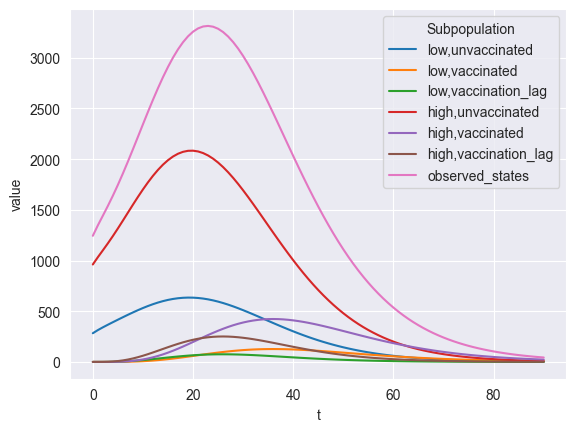

In [56]:
hospitalised_results = results_4_melted[results_4_melted['State']=='H']
sns.lineplot(hospitalised_results,x='t',y='value',hue='Subpopulation')

In [57]:
display({'Total hospitalisations': results_4.loc[90,('observed_states','H_cumulative')],
         'Peak hospitalisations': max(results_4.loc[:,('observed_states','H')])})

{'Total hospitalisations': 25527.116307391472,
 'Peak hospitalisations': 3314.17145377946}

# 5. New Vaccine's Efficacy is Uncertain: Latin Hypercube Sampling in simulation of a 2 dimensional/axis disease X model.

In [ ]:
from metacast.sensitivity_analyses import lhs_and_prcc_parallel